In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kumsc-data/Data/sample_submission.csv
/kaggle/input/kumsc-data/Data/tile_meta.csv
/kaggle/input/kumsc-data/Data/wsi_meta.csv
/kaggle/input/kumsc-data/Data/polygons.jsonl
/kaggle/input/kumsc-data/Data/ultralytics/ultralytics/CONTRIBUTING.md
/kaggle/input/kumsc-data/Data/ultralytics/ultralytics/.pre-commit-config.yaml
/kaggle/input/kumsc-data/Data/ultralytics/ultralytics/setup.cfg
/kaggle/input/kumsc-data/Data/ultralytics/ultralytics/LICENSE
/kaggle/input/kumsc-data/Data/ultralytics/ultralytics/.gitignore
/kaggle/input/kumsc-data/Data/ultralytics/ultralytics/README.zh-CN.md
/kaggle/input/kumsc-data/Data/ultralytics/ultralytics/README.md
/kaggle/input/kumsc-data/Data/ultralytics/ultralytics/MANIFEST.in
/kaggle/input/kumsc-data/Data/ultralytics/ultralytics/requirements.txt
/kaggle/input/kumsc-data/Data/ultralytics/ultralytics/CITATION.cff
/kaggle/input/kumsc-data/Data/ultralytics/ultralytics/setup.py
/kaggle/input/kumsc-data/Data/ultralytics/ultralytics/mkdocs.yml
/kaggle/inp

In [2]:
from itertools import chain
import json
import os
import shutil
from tqdm.notebook import tqdm
from colorama import Fore
import yaml
import numpy as np

In [3]:
class COCODataset:
    def __init__(self, images_dirpath: str, annotations_filepath: str, length: int = 1633):
        self.train_size = None
        self.val_size = None
        self.length = length
        self.classes = None
        self.labels_counter = None
        self.normalize = None
        
        self.images_dirpath = images_dirpath
        self.annotations_filepath = annotations_filepath
        self.dataset_dirpath = os.path.join(os.getcwd(), "dataset")
        self.train_dirpath =  os.path.join(self.dataset_dirpath, "train")
        self.val_dirpath =  os.path.join(self.dataset_dirpath, "val")
        self.config_path = os.path.join(self.dataset_dirpath, "coco.yaml")

        self.samples = self.parse_jsonl(annotations_filepath)
        self.classes_dict = {
            "blood_vessel": 0,
            "glomerulus": 1,
            "unsure": 2,
        }

    def __prepare_dirs(self) -> None:
        if not os.path.exists(self.dataset_dirpath):
            os.makedirs(os.path.join(self.train_dirpath, "images"), exist_ok=True)
            os.makedirs(os.path.join(self.train_dirpath, "labels"), exist_ok=True)
            os.makedirs(os.path.join(self.val_dirpath, "images"), exist_ok=True)
            os.makedirs(os.path.join(self.val_dirpath, "labels"), exist_ok=True)
        else:
            raise RuntimeError("Dataset already exists!")

    def __define_splitratio(self) -> None:
        self.train_size = round(self.length * self.train_size)
        self.val_size = self.length - self.train_size
        assert self.train_size + self.val_size == self.length

    def parse_jsonl(self, path: str) -> list[dict, ...]:
        with open(path, 'r') as json_file:
            jsonl_samples = [
                json.loads(line)
                for line in tqdm(
                    json_file, desc="Processing polygons", total=self.length
                )
            ]
        return jsonl_samples

    def __define_paths(self, i: int) -> dict:
        data_path = self.val_dirpath
        if i < self.train_size:
            data_path = self.train_dirpath
        return {
            "images": os.path.join(data_path, "images"),
            "labels": os.path.join(data_path, "labels")
        }

    @staticmethod
    def __get_label_path(paths_dict: dict, identifier: str) -> str:
        return os.path.join(
            paths_dict["labels"],
            f"{identifier}.txt"
        )

    @staticmethod
    def __get_image_path(paths_dict: dict, identifier: str) -> str:
        return os.path.join(
            paths_dict["images"],
            f"{identifier}.tif"
        )

    def __copy_image(self, dst_path: str, identifier: str) -> str:
        shutil.copyfile(
            os.path.join(self.images_dirpath, f"{identifier}.tif"),
            dst_path
        )

    def __copy_label(self, annotations: list, dst_path: str) -> None:
        with open(dst_path, "w") as file:
            for annotation in annotations:
                coordinates = annotation["coordinates"][0]
                label = self.classes_dict[annotation["type"]]
                if label in self.classes:
                    if coordinates:
                        if self.normalize:
                            coordinates = np.array(coordinates) / 512.0
                        coordinates = " ".join(map(str, chain(*coordinates)))
                        file.write(f"{label} {coordinates}\n")
                        self.labels_counter += 1

    def __splitfolders(self):
        for i, line in tqdm(
                enumerate(self.samples),
                desc="Dataset creation", total=self.length
        ):
            self.labels_counter = 0
            identifier = line["id"]
            annotations = line["annotations"]
            paths_dict = self.__define_paths(i)

            dst_image_path = self.__get_image_path(paths_dict, identifier)
            dst_label_path = self.__get_label_path(paths_dict, identifier)

            self.__copy_image(dst_image_path, identifier)
            self.__copy_label(annotations, dst_label_path)

            if self.labels_counter == 0:
                os.remove(dst_image_path)
                os.remove(dst_label_path)

    def __count_dataset(self) -> dict:
        train_images = len(os.listdir(os.path.join(self.train_dirpath, "images")))
        train_labels = len(os.listdir(os.path.join(self.train_dirpath, "labels")))
        val_images = len(os.listdir(os.path.join(self.val_dirpath, "images")))
        val_labels = len(os.listdir(os.path.join(self.val_dirpath, "labels")))
        return {
            "train_images": train_images,
            "train_labels": train_labels,
            "val_images": val_images,
            "val_labels": val_labels
        }

    @staticmethod
    def __check_sanity(count_dict: dict) -> None:
        assert count_dict["train_images"] == count_dict["train_labels"]
        assert count_dict["val_images"] == count_dict["val_labels"]

    def __finalizing(self, count_dict: dict) -> None:
        assert os.path.exists(self.dataset_dirpath)

        example_structure = [
            "dataset",
            "train", "labels", "images",
            "val", "labels", "images"
        ]

        dir_bone = (
            dirname.split("/")[-1]
            for dirname, _, filenames in os.walk(self.dataset_dirpath)
            if dirname.split("/")[-1] in example_structure
        )

        try:
            print("\n~ HuBMAP Dataset Structure ~\n")
            print(
            f"""
          ├── {next(dir_bone)}
          │   │
          │   ├── {next(dir_bone)}
          │   │   └── {next(dir_bone)}
          │   │   └── {next(dir_bone)}
          │   │
          │   ├── {next(dir_bone)}
          │   │   └── {next(dir_bone)}
          │   │   └── {next(dir_bone)}
            """
            )
        except StopIteration as e:
            print(e)
        else:
            print(Fore.GREEN + "-> Success")
            print(Fore.GREEN + f"Train dataset: {count_dict['train_images']}\nVal dataset: {count_dict['val_images']}")

    def get_config(self) ->dict:
        names = ["blood_vessel", "glomerulus", "unsure"]
        return {
            "train": str(self.train_dirpath),
            "val": str(self.val_dirpath),
            "names": [names[i] for i in self.classes]
        }

    @staticmethod
    def display_config(config: dict) -> None:
        print(Fore.BLACK + "\n~ HuBMAP Config Structure ~\n")
        print(
        f"""
      │   │
      │   ├── train
      │   │   └── {config['train']}/images
      │   │
      │   │
      │   ├── val
      │   │   └── {config['val']}/images
      │   │
      │   │
      │   ├── names
      │   │   └── {' '.join(config['names'])}
        """
        )
        print(Fore.GREEN + "-> Success")
        print(Fore.GREEN + f"Number of classes: {len(config['names'])}"
                           f"\nClasses: {' '.join(config['names'])}" 
              )

    def write_config(self, config: dict) -> None:
        with open(self.config_path, mode="w") as f:
            yaml.safe_dump(stream=f, data=config)

    def __call__(self, train_size: float,
                 classes: list[int, ...],
                 make_config: bool = True,
                 normalize: bool = True
                ) -> None:
        
        self.train_size = train_size
        self.classes = classes
        self.normalize = normalize
        
        self.__define_splitratio()
        self.__prepare_dirs()
        self.__splitfolders()
        count_dict = self.__count_dataset()
        self.__check_sanity(count_dict)
        self.__finalizing(count_dict)
        
        if make_config:
            config = self.get_config()
            self.write_config(config)
            self.display_config(config)

In [4]:
coco = COCODataset(
    annotations_filepath="/kaggle/input/kumsc-data/Data/polygons.jsonl",
    images_dirpath="/kaggle/input/kumsc-data/Data/train",
) 

Processing polygons:   0%|          | 0/1633 [00:00<?, ?it/s]

In [5]:
coco(train_size=0.80, classes=[0, 1, 2])

Dataset creation:   0%|          | 0/1633 [00:00<?, ?it/s]


~ HuBMAP Dataset Structure ~


          ├── dataset
          │   │
          │   ├── train
          │   │   └── labels
          │   │   └── images
          │   │
          │   ├── val
          │   │   └── labels
          │   │   └── images
            
-> Success
Train dataset: 1306
Val dataset: 327

~ HuBMAP Config Structure ~


      │   │
      │   ├── train
      │   │   └── /kaggle/working/dataset/train/images
      │   │
      │   │
      │   ├── val
      │   │   └── /kaggle/working/dataset/val/images
      │   │
      │   │
      │   ├── names
      │   │   └── blood_vessel glomerulus unsure
        
-> Success
Number of classes: 3
Classes: blood_vessel glomerulus unsure


In [6]:
import shutil
import os
import sys
from colorama import Fore

In [9]:
class SetupPipline:
    def __init__(self, display: bool = True):
        self.pycocotools = self.__pycocotools()
        self.ultralytics = self.__ultralytics()
        
    @staticmethod
    def __ultralytics() -> str:
        sys.path.append("/kaggle/input/kumsc-data/Data/ultralytics/ultralytics") 
        return "successfully"
        
    @staticmethod
    def __pycocotools() -> str:
        if not os.path.exists("/kaggle/working/packages"):
            shutil.copytree("/kaggle/input/kumsc-data/Data/pycocotools/pycocotools", "/kaggle/working/packages")
            os.chdir("/kaggle/working/packages/pycocotools-2.0.6/")
            os.system("python setup.py install")
            os.system("pip install . --no-index --find-links /kaggle/working/packages/")
            os.chdir("/kaggle/working")
            return "successfully"
    
    def display(self) -> None:
        print(Fore.GREEN+f"\nPycocotools was installed {self.pycocotools}")
        print(f"Ultralytics was installed {self.ultralytics}"+Fore.WHITE)

In [10]:
pipline = SetupPipline()

running install


/opt/conda/lib/python3.10/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/setuptools/command/easy_install.py:156: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(


running bdist_egg
running egg_info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
reading manifest file 'pycocotools.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib.linux-x86_64-3.10
creating build/lib.linux-x86_64-3.10/pycocotools
copying pycocotools/coco.py -> build/lib.linux-x86_64-3.10/pycocotools
copying pycocotools/cocoeval.py -> build/lib.linux-x86_64-3.10/pycocotools
copying pycocotools/mask.py -> build/lib.linux-x86_64-3.10/pycocotools
copying pycocotools/__init__.py -> build/lib.linux-x86_64-3.10/pycocotools
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c


/opt/conda/lib/python3.10/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /kaggle/working/packages/pycocotools-2.0.6/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


building 'pycocotools._mask' extension
creating build/temp.linux-x86_64-3.10
creating build/temp.linux-x86_64-3.10/common
creating build/temp.linux-x86_64-3.10/pycocotools
gcc -pthread -B /opt/conda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/conda/include -fPIC -O2 -isystem /opt/conda/include -fPIC -I/opt/conda/lib/python3.10/site-packages/numpy/core/include -I./common -I/opt/conda/include/python3.10 -c ./common/maskApi.c -o build/temp.linux-x86_64-3.10/./common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99


./common/maskApi.c: In function ‘rleToBbox’:
./common/maskApi.c:151:32: warning: unused variable ‘xp’ [-Wunused-variable]
  151 |     uint h, w, xs, ys, xe, ye, xp, cc; siz j, m;
      |                                ^~
./common/maskApi.c: In function ‘rleFrPoly’:
./common/maskApi.c:197:3: warning: this ‘for’ clause does not guard... [-Wmisleading-indentation]
  197 |   for(j=0; j<k; j++) x[j]=(int)(scale*xy[j*2+0]+.5); x[k]=x[0];
      |   ^~~
./common/maskApi.c:197:54: note: ...this statement, but the latter is misleadingly indented as if it were guarded by the ‘for’
  197 |   for(j=0; j<k; j++) x[j]=(int)(scale*xy[j*2+0]+.5); x[k]=x[0];
      |                                                      ^
./common/maskApi.c:198:3: warning: this ‘for’ clause does not guard... [-Wmisleading-indentation]
  198 |   for(j=0; j<k; j++) y[j]=(int)(scale*xy[j*2+1]+.5); y[k]=y[0];
      |   ^~~
./common/maskApi.c:198:54: note: ...this statement, but the latter is misleadingly indented as if it wer

gcc -pthread -B /opt/conda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/conda/include -fPIC -O2 -isystem /opt/conda/include -fPIC -I/opt/conda/lib/python3.10/site-packages/numpy/core/include -I./common -I/opt/conda/include/python3.10 -c pycocotools/_mask.c -o build/temp.linux-x86_64-3.10/pycocotools/_mask.o -Wno-cpp -Wno-unused-function -std=c99


pycocotools/_mask.c: In function ‘__pyx_pf_11pycocotools_5_mask_12iou’:
pycocotools/_mask.c:6144:31: warning: comparison of integer expressions of different signedness: ‘Py_ssize_t’ {aka ‘long int’} and ‘siz’ {aka ‘long unsigned int’} [-Wsign-compare]
 6144 |     if (unlikely(!((__pyx_t_8 == __pyx_v_n) != 0))) {
      |                               ^~
pycocotools/_mask.c:948:43: note: in definition of macro ‘unlikely’
  948 |   #define unlikely(x) __builtin_expect(!!(x), 0)
      |                                           ^


gcc -pthread -B /opt/conda/compiler_compat -shared -Wl,--allow-shlib-undefined -Wl,-rpath,/opt/conda/lib -Wl,-rpath-link,/opt/conda/lib -L/opt/conda/lib -Wl,--allow-shlib-undefined -Wl,-rpath,/opt/conda/lib -Wl,-rpath-link,/opt/conda/lib -L/opt/conda/lib build/temp.linux-x86_64-3.10/./common/maskApi.o build/temp.linux-x86_64-3.10/pycocotools/_mask.o -o build/lib.linux-x86_64-3.10/pycocotools/_mask.cpython-310-x86_64-linux-gnu.so
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.10/pycocotools/coco.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.10/pycocotools/_mask.cpython-310-x86_64-linux-gnu.so -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.10/pycocotools/cocoeval.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.10/pycocotools/mask.py -> build/bdist.linux-x86_64/egg/pycocotools
copying bui

zip_safe flag not set; analyzing archive contents...
pycocotools.__pycache__._mask.cpython-310: module references __file__


Processing dependencies for pycocotools==2.0.6
Searching for numpy==1.25.0
Best match: numpy 1.25.0
Adding numpy 1.25.0 to easy-install.pth file
Installing f2py script to /opt/conda/bin
Installing f2py3 script to /opt/conda/bin
Installing f2py3.10 script to /opt/conda/bin

Using /opt/conda/lib/python3.10/site-packages
Searching for matplotlib==3.7.2
Best match: matplotlib 3.7.2
Adding matplotlib 3.7.2 to easy-install.pth file

Using /opt/conda/lib/python3.10/site-packages
Searching for fonttools==4.40.0
Best match: fonttools 4.40.0
Adding fonttools 4.40.0 to easy-install.pth file
Installing fonttools script to /opt/conda/bin
Installing pyftmerge script to /opt/conda/bin
Installing pyftsubset script to /opt/conda/bin
Installing ttx script to /opt/conda/bin

Using /opt/conda/lib/python3.10/site-packages
Searching for python-dateutil==2.8.2
Best match: python-dateutil 2.8.2
Adding python-dateutil 2.8.2 to easy-install.pth file

Using /opt/conda/lib/python3.10/site-packages
Searching for k

In [13]:
pipline.display()


Pycocotools was installed successfully
Ultralytics was installed successfully


In [14]:
from pycocotools import _mask as coco_mask 
from ultralytics import YOLO

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [15]:
pip install clearml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.6 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.7.0
    Uninstalling PyJWT-2.7.0:
      Successfully uninstalled PyJWT-2.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 2023.621.222118 requires jupyter-server~=1.16, but you have jupyter-server 2.6.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [17]:
!clearml-init

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
ClearML SDK setup process

Please create new clearml credentials through the settings page in your `clearml-server` web app (e.g. http://localhost:8080//settings/workspace-configuration) 
Or create a free account at https://app.clear.ml/settings/workspace-configuration

In settings page, press "Create new credentials", then press "Copy to clipboard".

Paste copied configuration here:
^C
Traceback (most recent call last):
  File "/opt/conda/bin/clearml-init", line 8, in <module>
    sys.exit(main())
  File "/opt/conda/lib/python3.10/site-packages/clearml/cli/config/__main__.py", line 77, in main
    api_input = input()
KeyboardInterrupt


In [18]:
pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [20]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
Aborted!


In [21]:
def main():
    model = YOLO("yolov8x-seg.pt")
    model.train(
        # Project
        project="HuBMAP",
        name="yolov8x-seg",

        # Random Seed parameters
        deterministic=True,
        seed=43,

        # Data & model parameters
        data="/kaggle/working/dataset/coco.yaml", 
        save=True,
        save_period=5,
        pretrained=True,
        imgsz=512,

        # Training parameters
        epochs=20,
        batch=4,
        workers=8,
        val=True,
        device=0,

        # Optimization parameters
        lr0=0.018,
        patience=3,
        optimizer="SGD",
        momentum=0.947,
        weight_decay=0.0005,
        close_mosaic=3,
    )

In [22]:
if __name__ == '__main__':
    main()

100%|██████████| 137M/137M [00:01<00:00, 114MB/s]  
New https://pypi.org/project/ultralytics/8.0.159 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.120 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
yolo/engine/trainer: task=segment, mode=train, model=yolov8x-seg.pt, data=/kaggle/working/dataset/coco.yaml, epochs=20, patience=3, batch=4, imgsz=512, save=True, save_period=5, cache=False, device=0, workers=8, project=HuBMAP, name=yolov8x-seg, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=3, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, vis

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
100%|██████████| 6.23M/6.23M [00:00<00:00, 67.8MB/s]
AMP: checks passed ✅
train: Scanning /kaggle/working/dataset/train/labels... 1306 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1306/1306 [00:05<00:00, 248.95it/s]
train: WARNING ⚠️ /kaggle/working/dataset/train/images/005715f0a313.tif: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/dataset/train/images/01a7fca6263b.tif: 7 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/dataset/train/images/025ec20b8b73.tif: 7 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/dataset/train/images/02cf5c2db152.tif: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/dataset/train/images/033a656390b2.tif: 4 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/dataset/train/images/0672b96aaccc.tif: 4 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/dataset/train/images/07b809228ef4.tif: 4 duplicate labels removed
train: WAR

In [23]:
import matplotlib.pyplot as plt
from PIL import Image
dirlist = os.listdir("/kaggle/working/dataset/val/images")
print(dirlist[:5])

['f592b552a1af.tif', 'e176191e4f83.tif', 'd58a88fb6958.tif', 'f48f6580655c.tif', 'd850250778f2.tif']



image 1/1 /kaggle/working/../working/dataset/val/images/ed6a92a9410c.tif: 512x512 11 blood_vessels, 71.9ms
Speed: 8.0ms preprocess, 71.9ms inference, 15.6ms postprocess per image at shape (1, 3, 512, 512)


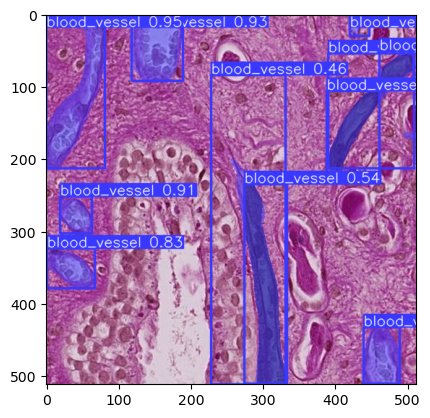

In [24]:
model = YOLO("/kaggle/working/HuBMAP/yolov8x-seg/weights/best.pt")
history = model.predict("../working/dataset/val/images/ed6a92a9410c.tif")[0]
image = history.plot()
plt.imshow(image)
plt.show()

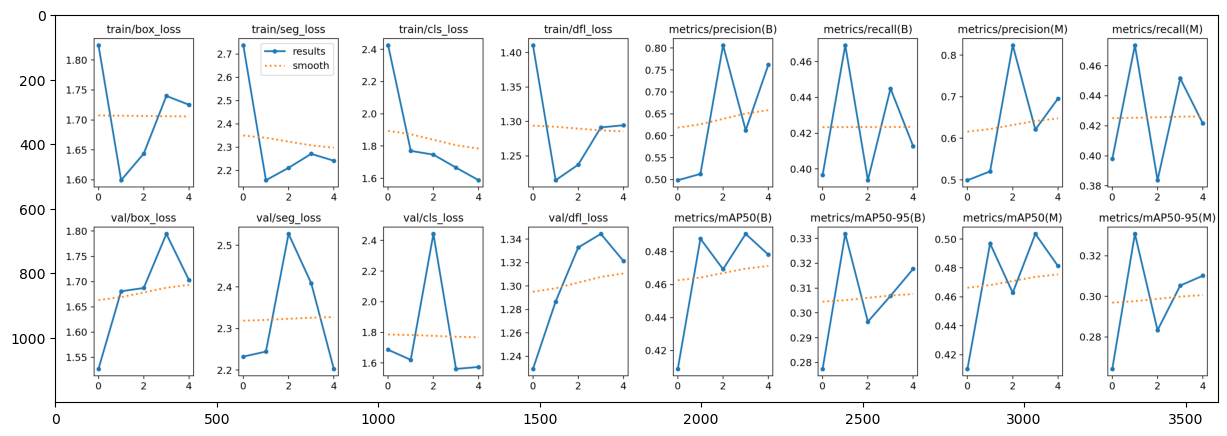

In [25]:
F1_curve = Image.open("/kaggle/working/HuBMAP/yolov8x-seg/results.png")
plt.figure(figsize=(15,20))
plt.imshow(F1_curve)
plt.show()